In [1]:
# Standard Library
import os
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path

# Visualize
import matplotlib.pyplot as plt

# Add src directory to Python path
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Project Modules
from modeling.data_modeling import (
    train_ranker,
    predict_rankings,
    save_model,
    get_feature_importance,
    split_data,
    extract_groundtruth,
    flatten_nested_dict,
    flatten_groundtruth
)
from evaluation.evaluation import calculate_mrr
from featureEngineering.feature_engineering import feature_engineering

# Configuration
INTERMEDIATE_DIR = "intermediate"
STUDENT_ID = "22127XXX"  # TODO: Change to your student ID
OUTPUT_DIR = f"../{STUDENT_ID}"

print("All imports loaded successfully")

All imports loaded successfully


---

## **STEP 1 - Load Data**

In [2]:
"""
STEP 1: Load Data
==================
"""

# Load labeled dataset
labeled_path = Path(INTERMEDIATE_DIR) / "labeled_dataset.csv"
if not labeled_path.exists():
    raise FileNotFoundError(f"File not found: {labeled_path}. Run Notebook 02 first!")

df_labeled = pd.read_csv(labeled_path)

# Summary
print(f"{'='*60}")
print(f"STEP 1: Data Loading Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_labeled)}")
print(f"  Positive (label=1): {(df_labeled['label'] == 1).sum()}")
print(f"  Negative (label=0): {(df_labeled['label'] == 0).sum()}")
print(f"  Columns: {list(df_labeled.columns)}")
print(f"{'='*60}")

df_labeled.head()

STEP 1: Data Loading Complete
  Total samples: 13432
  Positive (label=1): 343
  Negative (label=0): 13089
  Columns: ['pub_id', 'bib_key', 'bib_title_clean', 'bib_authors_clean', 'bib_author_tokens', 'bib_year', 'candidate_arxiv_id', 'candidate_title_clean', 'candidate_authors_clean', 'candidate_author_tokens', 'candidate_year', 'source', 'pair_type', 'label']


,pub_id,bib_key,bib_title_clean,bib_authors_clean,bib_author_tokens,bib_year,candidate_arxiv_id,candidate_title_clean,candidate_authors_clean,candidate_author_tokens,candidate_year,source,pair_type,label
0,2211-13752,isola2017image,imagetoimage translation conditional adversari...,"isola p, zhu j, zhou t, efros a","[['phillip', 'isola'], ['junyan', 'zhu'], ['ti...",2017.0,2105-05233,diffusion model beat gans image synthesis,"dhariwal p, nichol a","[['prafulla', 'dhariwal'], ['alex', 'nichol']]",2021.0,automatic,exhaustive_negative,0
1,2211-13752,richardson2020encoding,encoding style stylegan encoder imagetoimage t...,"richardson e, alaluf y, patashnik o, nitzan y,...","[['elad', 'richardson'], ['yuval', 'alaluf'], ...",2020.0,2105-05233,diffusion model beat gans image synthesis,"dhariwal p, nichol a","[['prafulla', 'dhariwal'], ['alex', 'nichol']]",2021.0,automatic,exhaustive_negative,0
2,2211-13771,cisse2017parseval,parseval network improving robustness adversar...,"cisse m, bojanowski p, grave e, dauphin y, usu...","[['moustapha', 'cisse'], ['piotr', 'bojanowski...",2017.0,2007-06631,tbasis compact representation neural network,"obukhov a, rakhuba m, georgoulis s, kanakis m,...","[['anton', 'obukhov'], ['maxim', 'rakhuba'], [...",2020.0,automatic,exhaustive_negative,0
3,2211-13755,neuralrecon,neuralrecon realtime coherent 3d reconstructio...,"sun j, xie y, chen l, zhou x, bao h","[['jiaming', 'sun'], ['yiming', 'xie'], ['ling...",2021.0,2011-01603,deep temporal fusion framework scene flow usin...,"schuster r, unger c, stricker d","[['rené', 'schuster'], ['c', 'unger'], ['d', '...",2020.0,automatic,exhaustive_negative,0
4,2211-13757,dreamfusion,dreamfusion textto3d using 2d diffusion,"poole b, jain a, barron j, mildenhall b","[['ben', 'poole'], ['ajay', 'jain'], ['jonatha...",2022.0,2010-02502,denoising diffusion implicit model,"song j, meng c, ermon s","[['jiaming', 'song'], ['chenlin', 'meng'], ['s...",2020.0,automatic,exhaustive_negative,0


---

## **STEP 2 - Feature Engineering**

In [3]:
"""
STEP 2: Feature Engineering
============================
Create features from labeled dataset.
"""

# Apply feature engineering
df_features = feature_engineering(df_labeled)

# Save featured dataset
featured_path = Path(INTERMEDIATE_DIR) / "featured_dataset.csv"
df_features.to_csv(featured_path, index=False)

# Summary
# Check for NaN/Inf
print(f"NaN values: {df_features.isna().sum().sum()}")
print(f"Inf values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")


print(f"{'='*60}")
print(f"STEP 2: Feature Engineering Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_features)}")
print(f"  Features created: {len([c for c in df_features.columns if c not in ['label', 'pub_id', 'bib_key', 'candidate_arxiv_id']])}")
print(f"  Saved to: {featured_path}")
print(f"{'='*60}")

# Show feature columns
print("\n Feature columns:")
for col in df_features.columns:
    print(f"   - {col}")

df_features.head()

NaN values: 0
Inf values: 0
STEP 2: Feature Engineering Complete
  Total samples: 13432
  Features created: 6
  Saved to: intermediate\featured_dataset.csv

 Feature columns:
   - label
   - pub_id
   - bib_key
   - candidate_arxiv_id
   - source
   - Title_Soft_Jaccard
   - Title_Length_Diff
   - Author_Overlap_Score
   - Author_Levenshtein_Ratio
   - Year_Diff


,label,pub_id,bib_key,candidate_arxiv_id,source,Title_Soft_Jaccard,Title_Length_Diff,Author_Overlap_Score,Author_Levenshtein_Ratio,Year_Diff
0,0,2211-13752,isola2017image,2105-05233,automatic,0.000,15,0.0,0.178241,4.0
1,0,2211-13752,richardson2020encoding,2105-05233,automatic,0.000,15,0.0,0.125047,1.0
2,0,2211-13771,cisse2017parseval,2007-06631,automatic,0.100,13,0.0,0.393746,3.0
3,0,2211-13755,neuralrecon,2011-01603,automatic,0.000,17,0.0,0.191800,1.0
4,0,2211-13757,dreamfusion,2010-02502,automatic,0.125,5,0.0,0.307143,2.0


---

## **STEP 3 - Train/Valid/Test Split**

In [4]:
"""
STEP 3: Train/Valid/Test Split
================================
Split dataset into Train, Validation, and Test sets.
"""

# Get paper IDs for manual and automatic sources
manual_pub_ids = df_features[df_features['source'] == 'manual']['pub_id'].unique().tolist()
auto_pub_ids = df_features[df_features['source'] == 'automatic']['pub_id'].unique().tolist()

print(f"Manual labeled publications: {len(manual_pub_ids)}")
print(f"Automatic labeled publications: {len(auto_pub_ids)}")

# Split data
df_train, df_val, df_test = split_data(df_features, manual_pub_ids=manual_pub_ids, auto_pub_ids=auto_pub_ids)

train_path = Path(INTERMEDIATE_DIR) / "train_dataset.csv"
val_path = Path(INTERMEDIATE_DIR) / "val_dataset.csv"
test_path = Path(INTERMEDIATE_DIR) / "test_dataset.csv"
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

# Summary
print(f"\n{'='*60}")
print(f"STEP 3: Data Split Complete")
print(f"{'='*60}")
print(f"  Train: {len(df_train)} samples ({df_train['pub_id'].nunique()} pubs)")
print(f"  Valid: {len(df_val)} samples ({df_val['pub_id'].nunique()} pubs)")
print(f"  Test:  {len(df_test)} samples ({df_test['pub_id'].nunique()} pubs)")
print(f"{'='*60}")

Manual labeled publications: 5
Automatic labeled publications: 24
Split summary:
  Train: 9961 rows, 21 publications
  Valid: 2159 rows, 2 publications
  Test:  1312 rows, 2 publications

STEP 3: Data Split Complete
  Train: 9961 samples (21 pubs)
  Valid: 2159 samples (2 pubs)
  Test:  1312 samples (2 pubs)


---

## **STEP 4 - Model Training**

In [5]:
"""
STEP 4: Model Training
=======================
Training với Negative Sampling để xử lý mất cân bằng dữ liệu
"""

USE_NEGATIVE_SAMPLING = True

K_NEGATIVES = 15

HARD_RATIO = 0.6

# Define feature columns
FEATURE_COLS = [
    # Title features
    "Title_Soft_Jaccard",
    "Title_Length_Diff",
    # Author features
    "Author_Overlap_Score",
    "Author_Levenshtein_Ratio",
    # Year features
    "Year_Diff"
]

# Get available features in the DataFrame
available_features = [f for f in FEATURE_COLS if f in df_train.columns]
print(f"Using {len(available_features)} features: {available_features}")

TARGET = "label"

# Check data imbalance before sampling
print(f"\nData imbalance BEFORE sampling:")
print(f"  Positives: {len(df_train[df_train[TARGET]==1])}")
print(f"  Negatives: {len(df_train[df_train[TARGET]==0])}")
print(f"  Ratio (pos:neg): 1:{len(df_train[df_train[TARGET]==0])/max(1, len(df_train[df_train[TARGET]==1])):.1f}")

# Train with configured negative sampling
model = train_ranker(
    df_train, 
    df_val, 
    features=available_features, 
    target=TARGET,
    use_negative_sampling=USE_NEGATIVE_SAMPLING,
    k_negatives=K_NEGATIVES,
    hard_ratio=HARD_RATIO
)

# Save model
model_path = save_model(model, INTERMEDIATE_DIR, filename="xgb_ranker.joblib")

print(f"\n{'='*60}")
print(f"STEP 4: Training Complete")
print(f"{'='*60}")

Using 5 features: ['Title_Soft_Jaccard', 'Title_Length_Diff', 'Author_Overlap_Score', 'Author_Levenshtein_Ratio', 'Year_Diff']

Data imbalance BEFORE sampling:
  Positives: 257
  Negatives: 9704
  Ratio (pos:neg): 1:37.8

Applying negative sampling to training data...

Negative Sampling Summary:
  Original: 9961 rows
  Sampled:  3892 rows
  Reduction: 60.9%
  Positives: 257
  Negatives: 3635
  Ratio (pos:neg): 1:14.1
Best iteration: 0
Best score: 0.9948419625702062
Model saved to: intermediate\xgb_ranker.joblib

STEP 4: Training Complete



Feature Importance:


,feature,importance
0,Title_Soft_Jaccard,0.884634
3,Author_Levenshtein_Ratio,0.045818
1,Title_Length_Diff,0.036121
2,Author_Overlap_Score,0.033427
4,Year_Diff,0.000000


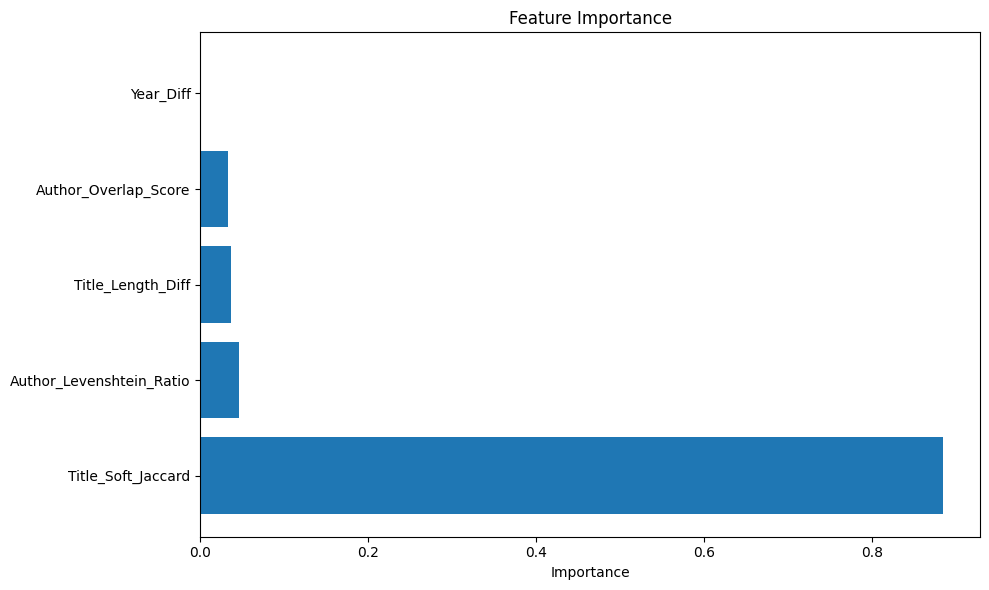

In [6]:
# Feature Importance
print("\nFeature Importance:")
importance_df = get_feature_importance(model, available_features)
display(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

---

## **STEP 5 - Prediction**

In [7]:
"""
STEP 5: Prediction & Export
=============================
Predict rankings
"""

# Predict on test set (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on test set...")
test_predictions = predict_rankings(model, df_test, available_features, top_k=5)

# Predict on validation set
print("Predicting on validation set...")
val_predictions = predict_rankings(model, df_val, available_features, top_k=5)

# Predict on train set
print("Predicting on train set...")
train_predictions = predict_rankings(model, df_train, available_features, top_k=5)

test_groundtruth = extract_groundtruth(df_test)
val_groundtruth = extract_groundtruth(df_val)
train_groundtruth = extract_groundtruth(df_train)

print(f"\nGroundtruth extracted:")
print(f"  Test: {sum(len(v) for v in test_groundtruth.values())} references across {len(test_groundtruth)} publications")
print(f"  Valid: {sum(len(v) for v in val_groundtruth.values())} references across {len(val_groundtruth)} publications")
print(f"  Train: {sum(len(v) for v in train_groundtruth.values())} references across {len(train_groundtruth)} publications")

Predicting on test set...
Predicting on validation set...
Predicting on train set...

Groundtruth extracted:
  Test: 35 references across 2 publications
  Valid: 50 references across 2 publications
  Train: 257 references across 21 publications


---

## **STEP 6 - Evaluation**

In [9]:
"""
STEP 6: Evaluation
===================
"""

# Flatten for evaluation
test_predictions_flat = flatten_nested_dict(test_predictions)
test_groundtruth_flat = flatten_groundtruth(test_groundtruth)

val_predictions_flat = flatten_nested_dict(val_predictions)
val_groundtruth_flat = flatten_groundtruth(val_groundtruth)

train_predictions_flat = flatten_nested_dict(train_predictions)
train_groundtruth_flat = flatten_groundtruth(train_groundtruth)

# Evaluate on test set
print("Evaluating on TEST set...")
test_mrr = calculate_mrr(test_predictions_flat, test_groundtruth_flat)
print(f"  Test MRR: {test_mrr:.4f}")

Evaluating on TEST set...
  Test MRR: 0.9714


In [13]:
"""
Comprehensive Evaluation: Train/Valid/Test MRR
================================================
Check for overfitting by comparing MRR across all partitions
"""

print("="*70)
print("MODEL EVALUATION")
print("="*70)

# Calculate MRR for all partitions
train_mrr = calculate_mrr(train_predictions_flat, train_groundtruth_flat)
val_mrr = calculate_mrr(val_predictions_flat, val_groundtruth_flat)
# test_mrr already calculated above

print("\n1. MRR Scores Across Partitions:")
print(f"  Train MRR: {train_mrr:.4f}")
print(f"  Valid MRR: {val_mrr:.4f}")
print(f"  Test MRR:  {test_mrr:.4f}")

# Check overfitting
train_test_gap = abs(train_mrr - test_mrr)
print(f"\n2. Overfitting Check:")
print(f"  Train-Test Gap: {train_test_gap:.4f}")
if train_test_gap < 0.05:
    print("  ✅ No significant overfitting detected!")
    print("  → Model generalizes well to unseen data")
elif train_test_gap < 0.10:
    print("  ⚠️  Slight overfitting (acceptable)")
else:
    print("  ❌ Significant overfitting detected!")
    print("  → Consider regularization or more data")

MODEL EVALUATION

1. MRR Scores Across Partitions:
  Train MRR: 0.9981
  Valid MRR: 0.9900
  Test MRR:  0.9714

2. Overfitting Check:
  Train-Test Gap: 0.0267
  ✅ No significant overfitting detected!
  → Model generalizes well to unseen data


---

## **STEP 7 - Export Final pred.json**

In [11]:
"""
STEP 7: Export Final pred.json
================================
Export pred.json files for all publications in the dataset.
"""

# Load all data to predict
df_all = pd.read_csv(Path(INTERMEDIATE_DIR) / "featured_dataset.csv")

# Get pub_ids for each partition
train_pub_ids = set(df_train['pub_id'].unique())
val_pub_ids = set(df_val['pub_id'].unique())
test_pub_ids = set(df_test['pub_id'].unique())

def get_partition(pub_id):
    """Determine which partition a publication belongs to"""
    if pub_id in test_pub_ids:
        return "test"
    elif pub_id in val_pub_ids:
        return "valid"
    elif pub_id in train_pub_ids:
        return "train"
    else:
        return "unknown"

# Predict rankings for ALL data (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on all data...")
all_predictions = predict_rankings(model, df_all, available_features, top_k=5)

# Extract groundtruth (nested dict: {pub_id: {bib_key: arxiv_id}})
all_groundtruth = extract_groundtruth(df_all)

# Export pred.json for each publication
exported = {"train": 0, "valid": 0, "test": 0, "unknown": 0}
for pub_id, predictions in all_predictions.items():
    pub_folder = Path(OUTPUT_DIR) / pub_id
    pub_folder.mkdir(parents=True, exist_ok=True)
    
    # Determine correct partition for this publication
    partition = get_partition(pub_id)
    
    # Build pred.json
    pred_json = {
        "partition": partition,
        "groundtruth": all_groundtruth.get(pub_id, {}),
        "prediction": predictions
    }
    
    # Export to file
    output_file = pub_folder / "pred.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(pred_json, f, indent=2, ensure_ascii=False)
    
    exported[partition] += 1

print(f"\n{'='*60}")
print(f"STEP 7: Export Complete")
print(f"{'='*60}")
print(f"  pred.json files exported:")
print(f"    - Train: {exported['train']}")
print(f"    - Valid: {exported['valid']}")
print(f"    - Test:  {exported['test']}")
print(f"  Output folder: {OUTPUT_DIR}/")
print(f"{'='*60}")

Predicting on all data...

STEP 7: Export Complete
  pred.json files exported:
    - Train: 21
    - Valid: 2
    - Test:  2
  Output folder: ../22127XXX/
